# ViT Model Testing w/ RSNA Pneumonia Dataset
Process:
> Split an image into patches and provide the sequence of linear embeddings of these patches as an input to a Transformer. Image patches are treated the same way as tokens (words) in an NLP application. We train
> the model on image classification in supervised fashion.

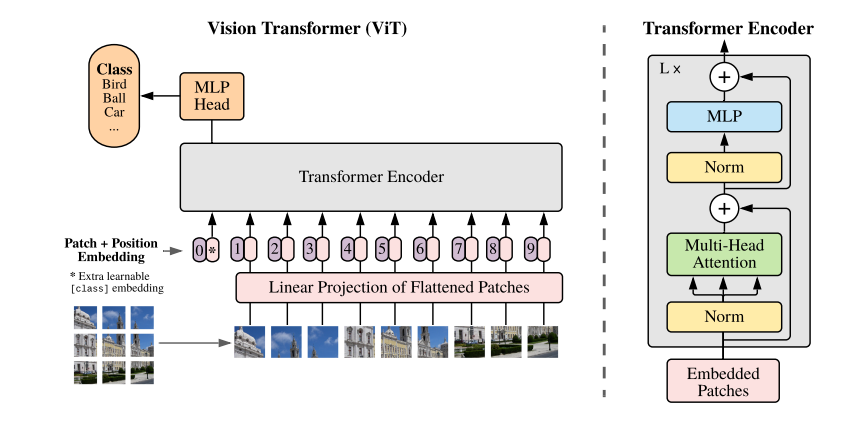

## Required Imports

> *NOTE* : You will need to convert the .dcm files to .jpg or .jpeg before being able to train the model. There is a script for that below.

In [1]:
import os
import torch
from torch import nn
import pydicom # used for image comversion

import pandas as pd
from torch import optim # for using ADAM
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit # tracking training time
from tqdm import tqdm # prgress bar

In [2]:
# see if gpu is detected
print(torch.cuda.is_available())
print(torch.backends.cuda.flash_sdp_enabled())
device = 'cuda' if torch.cuda.is_available() else "cpu"

True
True


## Accuracy and BATCH_SIZE
### MNIST
Based on changing the value of BATCH_SIZE:
- 512 gives 94.02% (original value) in 410 seconds (approx 7 min)
- 256 gives 95%
- 64 gives 96.48%
- 32 gives 97.02%
- 8 gives 97.4%
- 4 gives 97.9% in 5701 seconds (approx 1 hr 35 min)
- 2 gives 97.8% in 11147 seconds (approx 3 hours)


### RSNA Pneumonia
- 512 gives 79% in 9830s (approx 3 hours)
- 32 gives T : 81.32% and V : 81.9% in 332 min 

keep decreasing the BATCH_SIZE as it uses more 3D processing of GPU, as increasing uses more VRAM

Higher the BATCH_SIZE value, the quicker the training, but less accurate. The smaller the value, more training time, better generalization (performance on unseen data), but more accurate. 

In [3]:
RANDOM_SEED = 42
BATCH_SIZE = 32 # number of samples propogated (16 or 32 for med datasets)
EPOCHS = 10 # number of iterations of training dataset (was 40)

LEARNING_RATE = 1e-4
NUM_CLASSES = 2 # due to binary classification
PATCH_SIZE = 8 # was 4
IMG_SIZE = 224 #image resolution size (dont make it too low as it might lose imp details)
INPUT_CHANNELS = 1
NUM_HEADS = 8 # DECIDES HOW MANY ATTENTION HEADS WE WILL USE
DROPOUT = 0.001
HIDDEN_DIMENSION = 768 # HIDDEN DIMENSION OF MLP HEAD (was 768)
ADAM_WEIGHT_DECAY = 0 # WEIGHT DECAY WE WILL GIVE TO THE OPTIMIZER, IN THE PAPER THE VALUE DOES NOT WORK AS WELL
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUMBER_ENCODERS = 4
EMBEDDED_DIMENSION = (PATCH_SIZE ** 2) * INPUT_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Patch Embedding Class
Patch Embedding is the part that goes into the transformer encoder. Here, we convert the image to a sequence of patches and add positional embeddings.

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = embed_dim,
                kernel_size = patch_size,
                stride = patch_size
            ),
            nn.Flatten(2)
        )
        
        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad = True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)


    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) #-1 means that the dimension is not mutable

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)

        x = self.position_embeddings + x # dont need this if .to(device) is enabled in sample tensor in ViT class????
        x = self.dropout(x)
        
        return x

# TESTING
model = PatchEmbedding(EMBEDDED_DIMENSION, PATCH_SIZE, NUM_PATCHES, DROPOUT, INPUT_CHANNELS).to(device)
# x = torch.randn(512, 1, 224, 224).to(device)
# print(model(x).shape)

## Vision Transformer Class
Here, we conbine the PatchEmbedding, the transformer encoder and the MLP (Multi-Layer Perceptron) Head for the classification to take place.

- Job for MLP Head:
> Takes the output from the transformer encoder and then maps it to the final 'class' predictions.

In [5]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead = num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :]) # taking the token only in the beginning
        return x

#TESTING
model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBEDDED_DIMENSION, NUMBER_ENCODERS, NUM_HEADS, HIDDEN_DIMENSION, DROPOUT, ACTIVATION, INPUT_CHANNELS).to(device)
# x = torch.randn(512, 1, 224, 224).to(device)
# print(model(x).shape)

g:\ViT model test\env\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Defining Custom DataSet Classes

In [6]:
class_info_df = pd.read_csv('rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
labels_df = pd.read_csv('rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

In [7]:
class RSNADataset(Dataset):
    def __init__(self, images_dir, labels_df, class_info_df, transform=None):
        self.images_dir = images_dir
        self.labels_df = labels_df
        self.class_info_df = class_info_df
        self.transform = transform

        # merging the labels and the class info
        self.data = pd.merge(labels_df, class_info_df, on='patientId')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_name = self.data.iloc[index]['patientId']
        img_path = os.path.join(self.images_dir, f"{img_name}.jpeg")

        # loading image
        image = Image.open(img_path)

        # getting label
        label = self.data.iloc[index]['Target']

        if self.transform:
            image = self.transform(image)

        return {'image': image, 'label': label, 'index': index}


class RSNATestDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.image_names = [img for img in os.listdir(images_dir) if img.endswith('.jpeg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        return {'image': image, 'index': img_name.split('.')[0]}


In [8]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

## DataLoaders
We set shuffle = True as we malke sure model does not learn any dependant patterns

In [9]:
train_dataset = RSNADataset(images_dir='rsna-pneumonia-detection-challenge/stage_2_train_images_converted',
                                 labels_df=labels_df,
                                 class_info_df=class_info_df,
                                 transform=train_transforms)

val_dataset = RSNADataset(images_dir='rsna-pneumonia-detection-challenge/stage_2_train_images_converted',
                               labels_df=labels_df,
                               class_info_df=class_info_df,
                               transform=val_transforms)

test_dataset = RSNATestDataset(images_dir='rsna-pneumonia-detection-challenge/stage_2_test_images_converted', transform=val_transforms)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## Train Loop

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Training Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Validity Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Training Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Validity Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  0%|          | 0/1176 [00:00<?, ?it/s]g:\ViT model test\env\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 1176/1176 [03:04<00:00,  6.36it/s]


------------------------------
Training Loss EPOCH 1: 0.5764
Validity Loss EPOCH 1: 0.5269
Training Accuracy EPOCH 1: 0.6914


 10%|█         | 1/10 [08:29<1:16:24, 509.38s/it]

Validity Accuracy EPOCH 1: 0.7436
------------------------------


100%|██████████| 1176/1176 [03:05<00:00,  6.33it/s]


------------------------------
Training Loss EPOCH 2: 0.5240
Validity Loss EPOCH 2: 0.5288
Training Accuracy EPOCH 2: 0.7470


 20%|██        | 2/10 [16:58<1:07:53, 509.13s/it]

Validity Accuracy EPOCH 2: 0.7421
------------------------------


100%|██████████| 1176/1176 [03:06<00:00,  6.32it/s]


------------------------------
Training Loss EPOCH 3: 0.5004
Validity Loss EPOCH 3: 0.5038
Training Accuracy EPOCH 3: 0.7620


 30%|███       | 3/10 [25:33<59:43, 511.88s/it]  

Validity Accuracy EPOCH 3: 0.7667
------------------------------


100%|██████████| 1176/1176 [03:06<00:00,  6.30it/s]


------------------------------
Training Loss EPOCH 4: 0.4930
Validity Loss EPOCH 4: 0.4857
Training Accuracy EPOCH 4: 0.7684


 40%|████      | 4/10 [34:06<51:12, 512.16s/it]

Validity Accuracy EPOCH 4: 0.7711
------------------------------


100%|██████████| 1176/1176 [03:07<00:00,  6.27it/s]


------------------------------
Training Loss EPOCH 5: 0.4865
Validity Loss EPOCH 5: 0.4775
Training Accuracy EPOCH 5: 0.7720


 50%|█████     | 5/10 [42:40<42:44, 512.83s/it]

Validity Accuracy EPOCH 5: 0.7770
------------------------------


100%|██████████| 1176/1176 [03:07<00:00,  6.28it/s]


------------------------------
Training Loss EPOCH 6: 0.4811
Validity Loss EPOCH 6: 0.4825
Training Accuracy EPOCH 6: 0.7746


 60%|██████    | 6/10 [51:12<34:11, 512.82s/it]

Validity Accuracy EPOCH 6: 0.7731
------------------------------


100%|██████████| 1176/1176 [03:06<00:00,  6.30it/s]


------------------------------
Training Loss EPOCH 7: 0.4779
Validity Loss EPOCH 7: 0.4699
Training Accuracy EPOCH 7: 0.7791


 70%|███████   | 7/10 [59:44<25:37, 512.48s/it]

Validity Accuracy EPOCH 7: 0.7803
------------------------------


100%|██████████| 1176/1176 [03:06<00:00,  6.29it/s]


------------------------------
Training Loss EPOCH 8: 0.4742
Validity Loss EPOCH 8: 0.4750
Training Accuracy EPOCH 8: 0.7788


 80%|████████  | 8/10 [1:08:18<17:05, 512.78s/it]

Validity Accuracy EPOCH 8: 0.7762
------------------------------


100%|██████████| 1176/1176 [03:08<00:00,  6.24it/s]


------------------------------
Training Loss EPOCH 9: 0.4706
Validity Loss EPOCH 9: 0.4641
Training Accuracy EPOCH 9: 0.7816


 90%|█████████ | 9/10 [1:16:52<08:33, 513.41s/it]

Validity Accuracy EPOCH 9: 0.7830
------------------------------


100%|██████████| 1176/1176 [03:08<00:00,  6.25it/s]


------------------------------
Training Loss EPOCH 10: 0.4666
Validity Loss EPOCH 10: 0.4588
Training Accuracy EPOCH 10: 0.7838


100%|██████████| 10/10 [1:25:27<00:00, 512.79s/it]

Validity Accuracy EPOCH 10: 0.7884
------------------------------
Training Time: 5127.90s


In [11]:
# Clear CUDA GPU Cache
torch.cuda.empty_cache()

In [12]:
# running test data through the model
test_labels = []
test_images = []
test_indices = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        indices = sample["index"]
        
        outputs = model(img)
        preds = torch.argmax(outputs, dim=1)

        test_labels.extend(preds.cpu().numpy())
        test_images.extend(img.cpu().numpy())
        test_indices.extend(indices)

# lists to numpy arrays
test_labels = np.array(test_labels)
test_images = np.array(test_images)
test_indices = np.array(test_indices)


100%|██████████| 94/94 [00:30<00:00,  3.07it/s]


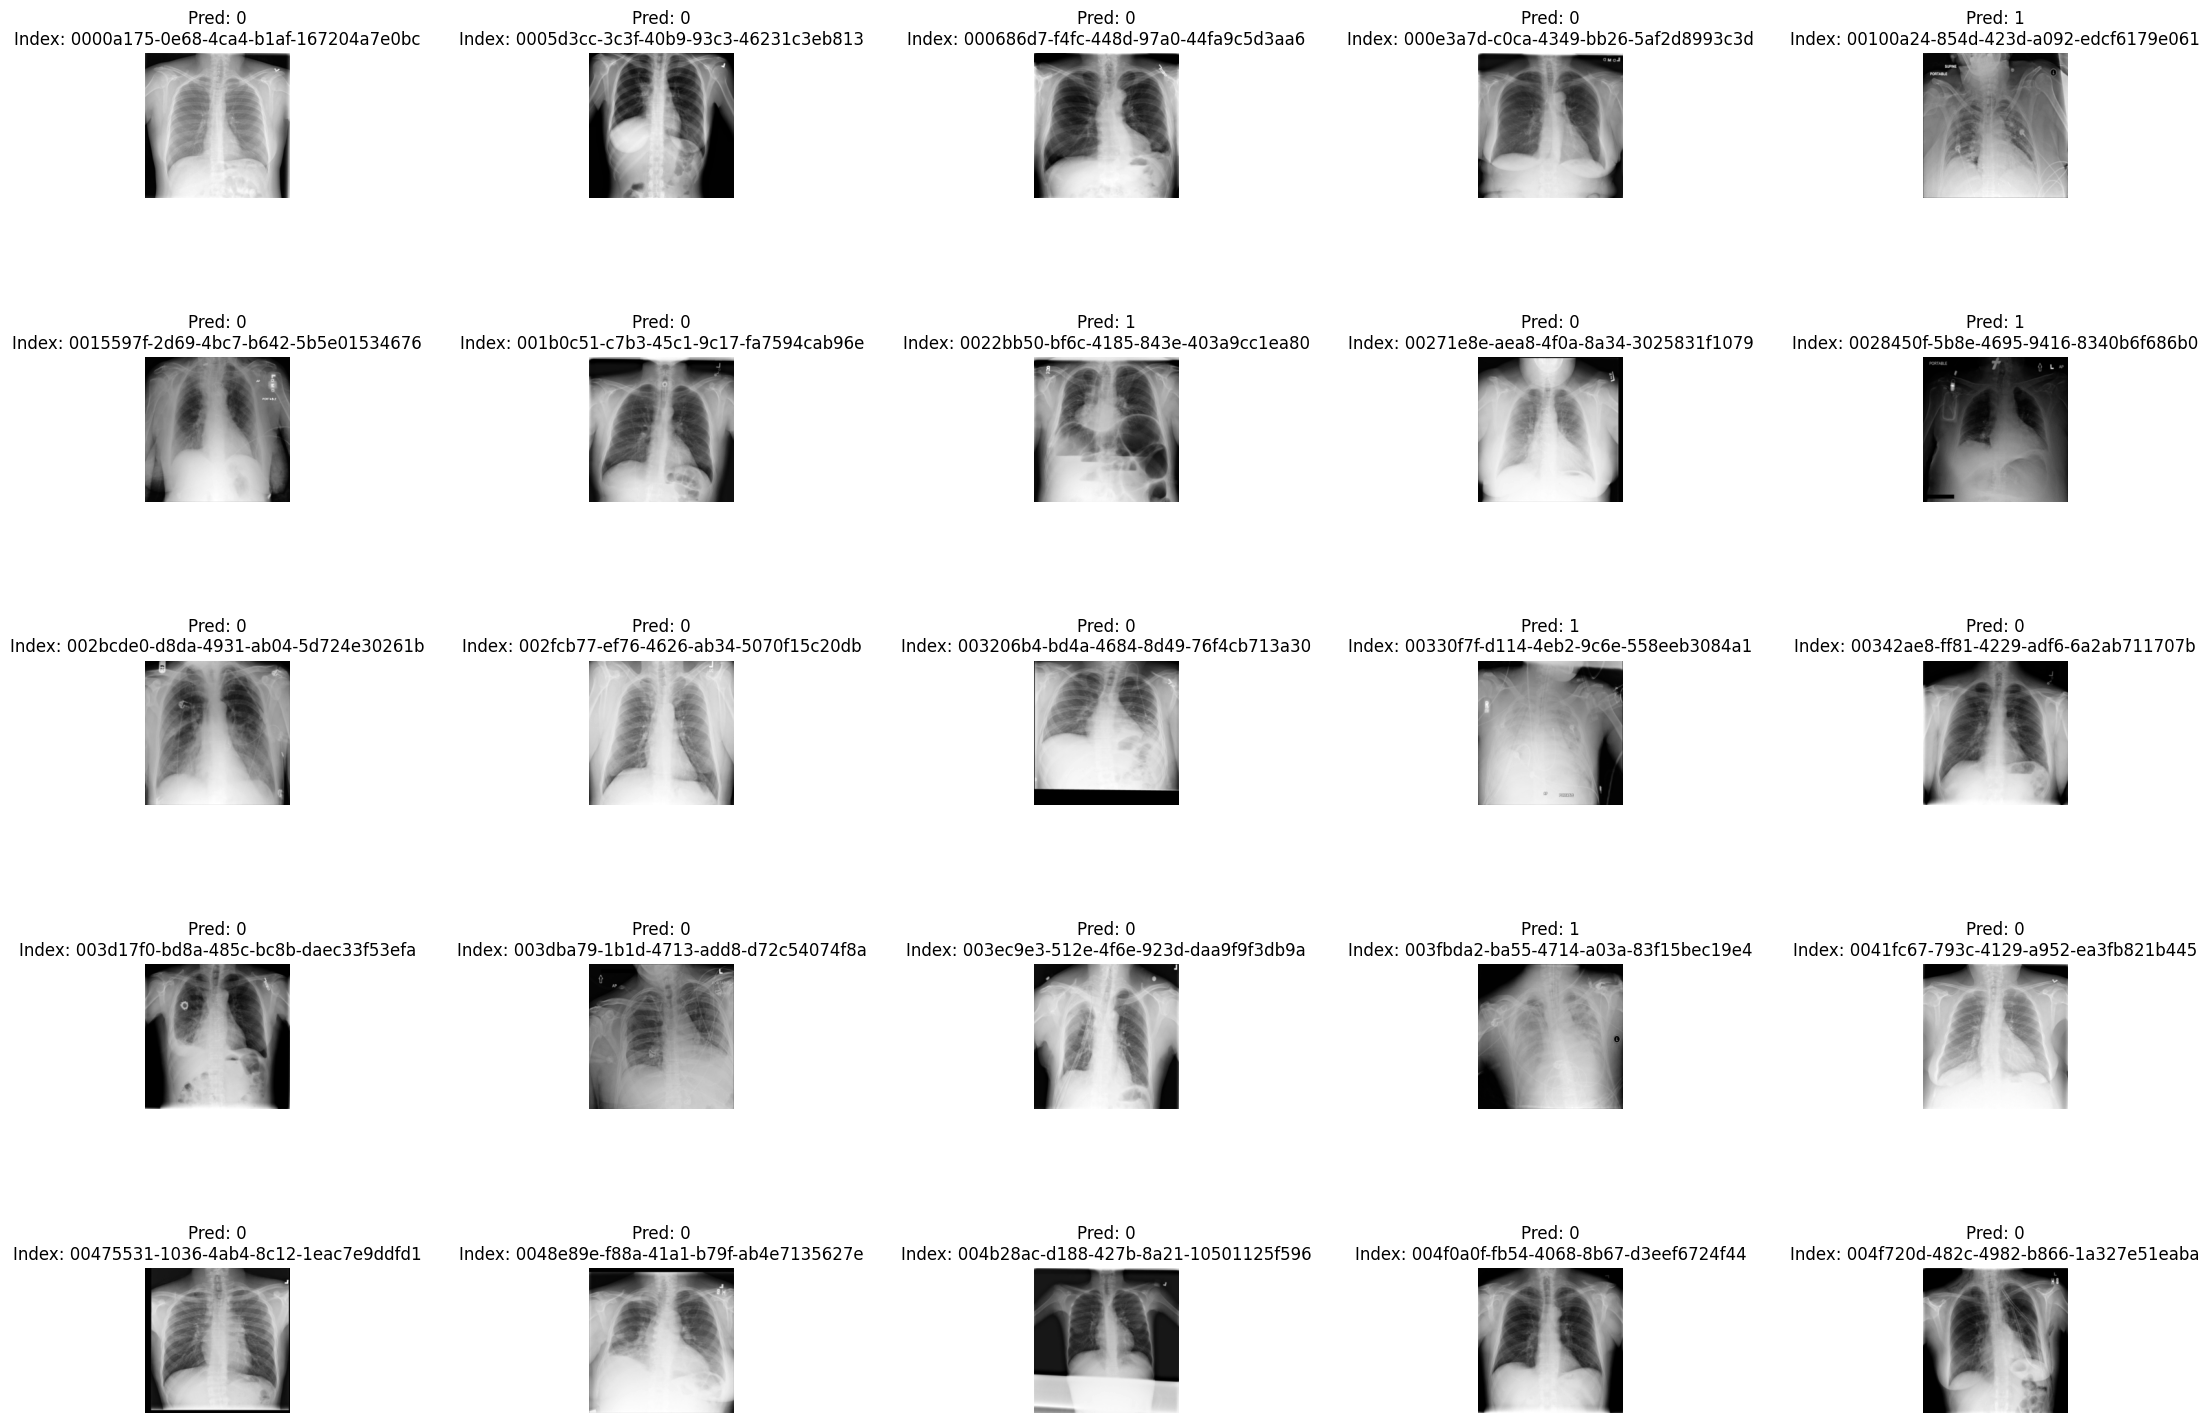

In [13]:
def display_samples(images, labels, indices, num_samples=25):
    plt.figure(figsize=(16, 16))
    for i in range(num_samples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)), cmap="gray")  # convert from (C, H, W) to (H, W, C)
        plt.title(f"Pred: {labels[i]}\nIndex: {indices[i]}")
        # plt.title(f"Pred: {labels[i]}")
        plt.axis('off')

    plt.subplots_adjust(left=1.05, right=2.3, top=1.9, bottom=1.05, hspace=1.1, wspace=1) 

    plt.show()

display_samples(test_images, test_labels, test_indices, num_samples=25)

## Converting .dcm to .jpg/.jpeg
> You only need to run this once as the .dcm images dont need to be converted multiple times. remember to download the dataset locally and correctly set the paths.

In [ ]:
class Converters():
    def convert_dcm_to_jpeg(dcm_folder, jpeg_folder):
        if not os.path.exists(jpeg_folder):
            os.makedirs(jpeg_folder)

        for filename in os.listdir(dcm_folder):
            if filename.endswith(".dcm"):
                dcm_path = os.path.join(dcm_folder, filename)
                ds = pydicom.dcmread(dcm_path)

                img_array = ds.pixel_array
                img_array = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array)) * 255
                img_array = img_array.astype(np.uint8)
                
                img = Image.fromarray(img_array)
                
                jpeg_filename = filename.replace(".dcm", ".jpeg")
                jpeg_path = os.path.join(jpeg_folder, jpeg_filename)
                img.save(jpeg_path)
                print(f"Converted {dcm_path} to {jpeg_path}")

In [ ]:
dcm_train_folder = "rsna-pneumonia-detection-challenge/stage_2_train_images"
jpeg_train_folder = "rsna-pneumonia-detection-challenge\stage_2_train_images_converted"
Converters.convert_dcm_to_jpeg(dcm_train_folder, jpeg_train_folder)

dcm_test_folder = "rsna-pneumonia-detection-challenge\stage_2_test_images"
jpeg_test_folder = "rsna-pneumonia-detection-challenge\stage_2_test_images_converted"
Converters.convert_dcm_to_jpeg(dcm_test_folder, jpeg_test_folder)